# Video Game Sales Prediction Pipeline
**Developers:** Kylen Bregula, Isaiah Herard, Lazaro Loureiro


**Description:** 

This notebook performs a complete pipeline for predicting global video game sales, including:
- Data loading
- Cleaning & preprocessing
- Feature engineering
- Exploratory Data Analysis (EDA)
- Model training & evaluation
- Saving results and models


# Imports and Warnings
This cell imports all necessary Python libraries for data manipulation, visualization, and machine learning. Warnings are suppressed for cleaner output.


In [24]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Data manipulation and numerical computing
import pandas as pd       # For dataframes and data analysis
import numpy as np        # For numerical operations

# Visualization libraries
import matplotlib.pyplot as plt  # For creating plots
import seaborn as sns             # For statistical data visualization

# Scikit-learn imports for machine learning
from sklearn.model_selection import train_test_split, KFold, cross_val_score  
# - train_test_split: split data into train/test sets
# - KFold: for cross-validation
# - cross_val_score: compute cross-validated scores for models

from sklearn.pipeline import Pipeline  # To create modeling pipelines
from sklearn.compose import ColumnTransformer  # To apply transformations to subsets of features
from sklearn.impute import SimpleImputer      # To handle missing values
from sklearn.preprocessing import StandardScaler, OneHotEncoder  
# - StandardScaler: scale numeric features
# - OneHotEncoder: encode categorical features

from sklearn.linear_model import LinearRegression      # Linear regression model
from sklearn.tree import DecisionTreeRegressor          # Decision tree regression
from sklearn.ensemble import RandomForestRegressor      # Random forest regression

# Metrics for evaluating model performance
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error  
# - r2_score: coefficient of determination
# - root_mean_squared_error: RMSE
# - mean_absolute_error: MAE


# Constants
Defines important constants for file paths, random seeds, train/test/validation split ratios, and number of cross-validation folds.


In [25]:
DATA_FILENAME = "Video_Games_Sales.csv"  # Input dataset file
RESULTS_CSV = "model_results.csv"        # File to save model evaluation results
RANDOM_STATE = 1958                      # Seed for reproducibility also the year of first video game ever made!
TEST_SIZE = 0.15                         # Proportion of data for the test set (15%)
VAL_SIZE = 0.1765                        # Proportion of train_val used as validation (15/85 = 0.1765 for 70/15/15 split)
N_FOLDS = 5                              # Number of folds for K-Fold cross-validation


# Evaluation Functions
Functions to calculate R², RMSE, and MAE metrics for model evaluation.


In [26]:
def rmse(y_true, y_pred):
    """
    Compute Root Mean Squared Error (RMSE)
    
    Parameters:
    y_true : array-like of true target values
    y_pred : array-like of predicted values
    
    Returns:
    float : RMSE
    """
    return root_mean_squared_error(y_true, y_pred)

def evaluate(y_true, y_pred):
    """
    Evaluate model predictions using R², RMSE, and MAE
    
    Parameters:
    y_true : array-like of true target values
    y_pred : array-like of predicted values
    
    Returns:
    dict : Dictionary with 'r2', 'rmse', 'mae' metrics
    """
    return {
        "r2": r2_score(y_true, y_pred),
        "rmse": rmse(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred)
    }


# Load Data
Loads the dataset from a CSV file and displays the first few rows to inspect the data.


In [27]:
# Load the dataset
df = pd.read_csv(DATA_FILENAME)

# Display the shape of the dataset
print(f"Original rows: {df.shape[0]}, columns: {df.shape[1]}")

# Display the first 5 rows
df.head()


Original rows: 16719, columns: 16


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning & Feature Engineering
Cleans the dataset by handling missing values, converting columns to numeric types, consolidating publishers, creating new features like Decade and Publisher_reduced, and transforming the target variable with log1p.


In [28]:
def clean_and_engineer(df):
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]
    df = df.replace(r'^\s*$', np.nan, regex=True)

    # Standardize text columns
    text_cols = ["Publisher", "Developer", "Genre", "Platform", "Rating", "Name"]
    for c in text_cols:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip().replace({"nan": np.nan})

    # Map known Publisher variations to ensure consistency
    if "Publisher" in df.columns:
        pub_map = {
            "Ea Sports": "Electronic Arts",
            "Ea": "Electronic Arts",
            "Electronic Arts Inc.": "Electronic Arts",
            "Nintendo Epd": "Nintendo",
            "Nintendo E": "Nintendo"
        }
        df["Publisher"] = df["Publisher"].replace(pub_map)

    # Convert numeric columns to proper types
    numeric_cols = ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales",
                    "Global_Sales", "Critic_Score", "Critic_Count",
                    "User_Score", "User_Count", "Year_of_Release"]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Handle special cases for User_Score ("tbd" values)
    if "User_Score" in df.columns:
        df["User_Score"] = df["User_Score"].replace({"tbd": np.nan})

    # Drop rows with missing Global_Sales (target variable)
    if "Global_Sales" in df.columns:
        df = df.dropna(subset=["Global_Sales"])

    # Drop duplicates
    df = df.drop_duplicates()

    # === MISSING VALUE HANDLING (Per Report Specifications) ===
    impute_values = {}
    
    # Impute Year_of_Release with median
    if "Year_of_Release" in df.columns:
        median_year = int(df["Year_of_Release"].median(skipna=True))
        df["Year_of_Release"] = df["Year_of_Release"].fillna(median_year).astype(int)
        impute_values["Year_of_Release"] = median_year
    
    # Impute Critic_Score with median
    if "Critic_Score" in df.columns:
        median_critic = float(df["Critic_Score"].median(skipna=True))
        df["Critic_Score"] = df["Critic_Score"].fillna(median_critic)
        impute_values["Critic_Score"] = median_critic
    
    # Impute Critic_Count with median
    if "Critic_Count" in df.columns:
        median_critic_count = float(df["Critic_Count"].median(skipna=True))
        df["Critic_Count"] = df["Critic_Count"].fillna(median_critic_count)
        impute_values["Critic_Count"] = median_critic_count
    
    # Impute User_Score with median
    if "User_Score" in df.columns:
        median_user = float(pd.to_numeric(df["User_Score"], errors="coerce").median(skipna=True))
        df["User_Score"] = df["User_Score"].fillna(median_user)
        impute_values["User_Score"] = median_user
    
    # Impute User_Count with median
    if "User_Count" in df.columns:
        median_user_count = float(df["User_Count"].median(skipna=True))
        df["User_Count"] = df["User_Count"].fillna(median_user_count)
        impute_values["User_Count"] = median_user_count
    
    # Fill categorical variables with "Unknown" (per report)
    if "Publisher" in df.columns:
        df["Publisher"] = df["Publisher"].fillna("Unknown")
    if "Developer" in df.columns:
        df["Developer"] = df["Developer"].fillna("Unknown")
    if "Rating" in df.columns:
        df["Rating"] = df["Rating"].fillna("Unknown")

    # === OUTLIER HANDLING (IQR Method at 95th percentile per Report) ===
    if "Global_Sales" in df.columns:
        # Cap outliers at 95th percentile as per report
        Q95 = df["Global_Sales"].quantile(0.95)
        df["Global_Sales"] = df["Global_Sales"].clip(upper=Q95)
        impute_values["Global_Sales_Q95"] = Q95

    # Feature engineering: Decade
    if "Year_of_Release" in df.columns:
        df["Decade"] = (df["Year_of_Release"] // 10) * 10

    # Reduce Publisher categories (top 30 + Other)
    if "Publisher" in df.columns:
        top_n = 30
        top_publishers = df["Publisher"].value_counts().nlargest(top_n).index
        df["Publisher_reduced"] = df["Publisher"].where(df["Publisher"].isin(top_publishers), other="Other")

    # Compute regional sales percentages
    for col in ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]:
        if col in df.columns and "Global_Sales" in df.columns:
            df[f"{col}_pct"] = df[col] / df["Global_Sales"]

    # Log-transform Global_Sales (for modeling)
    df["Global_Sales_log1p"] = np.log1p(df["Global_Sales"])

    return df, impute_values

# Clean and engineer the dataset
df_clean, impute_values = clean_and_engineer(df)
print(f"Rows after cleaning: {df_clean.shape[0]}, columns: {df_clean.shape[1]}")
impute_values


Rows after cleaning: 16719, columns: 23


{'Year_of_Release': 2007,
 'Critic_Score': 71.0,
 'Critic_Count': 21.0,
 'User_Score': 7.5,
 'User_Count': 24.0,
 'Global_Sales_Q95': np.float64(2.04)}

# Exploratory Data Analysis (EDA)
Visualizes distributions, top categories, correlations, and trends in the dataset.


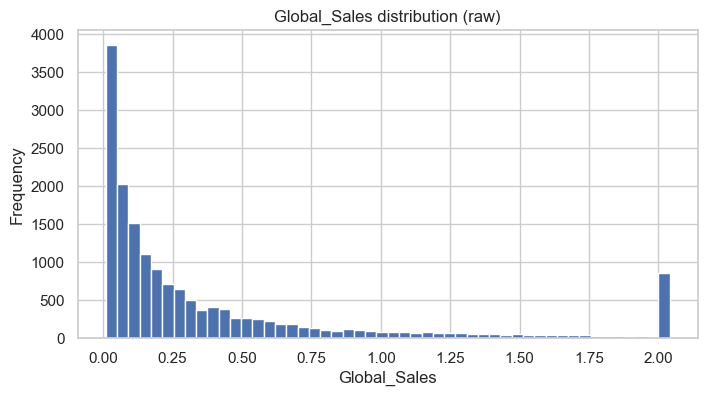

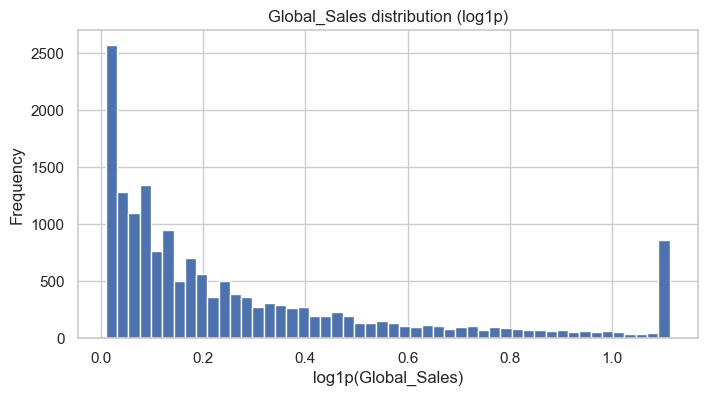

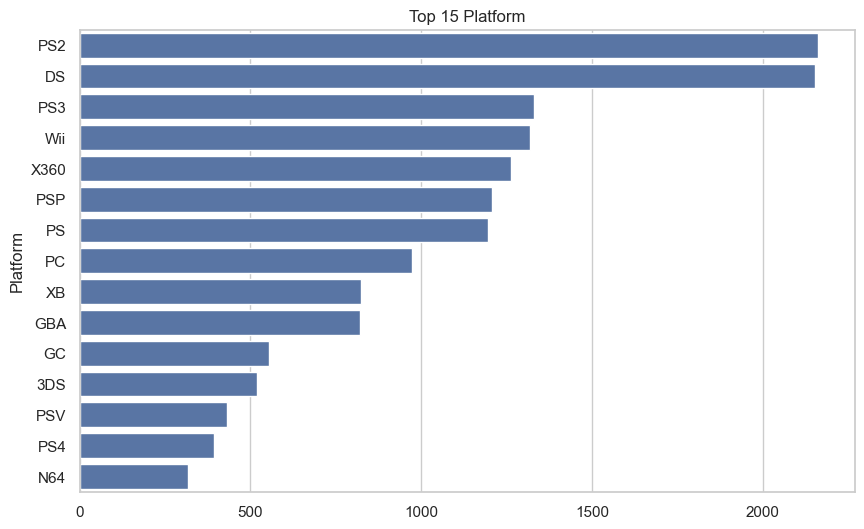

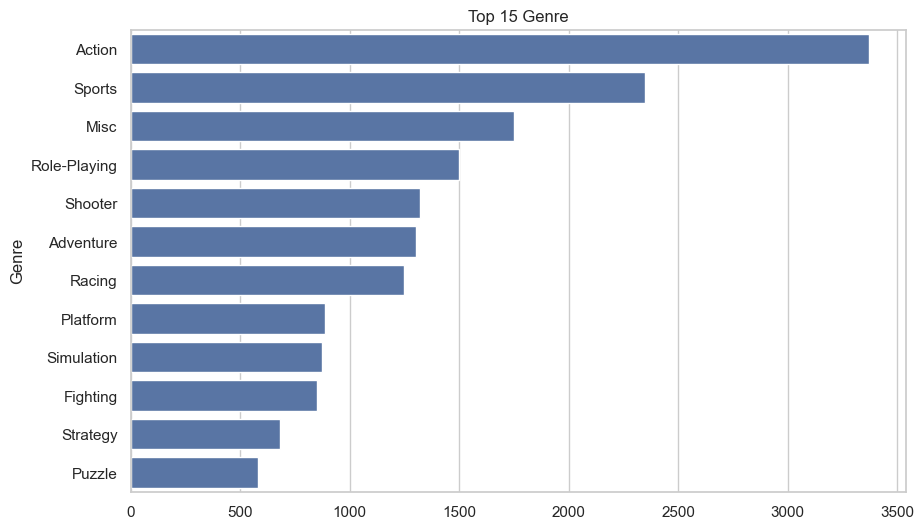

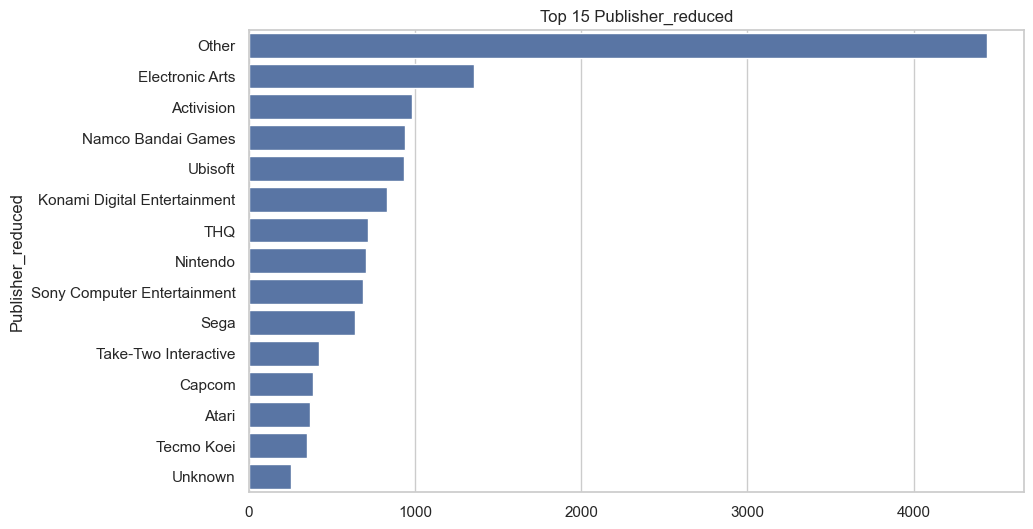

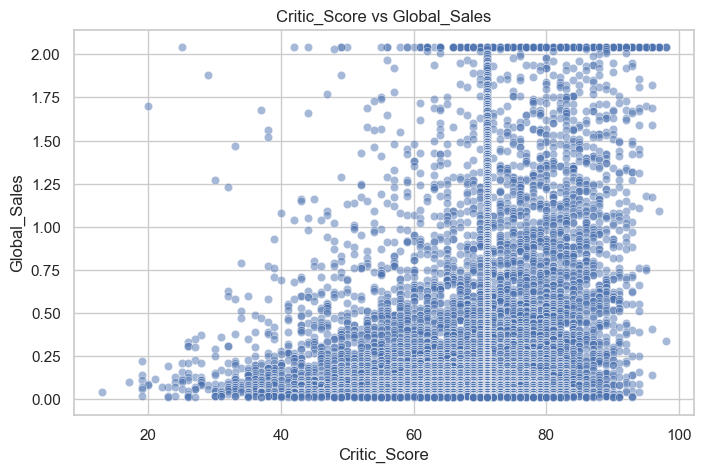

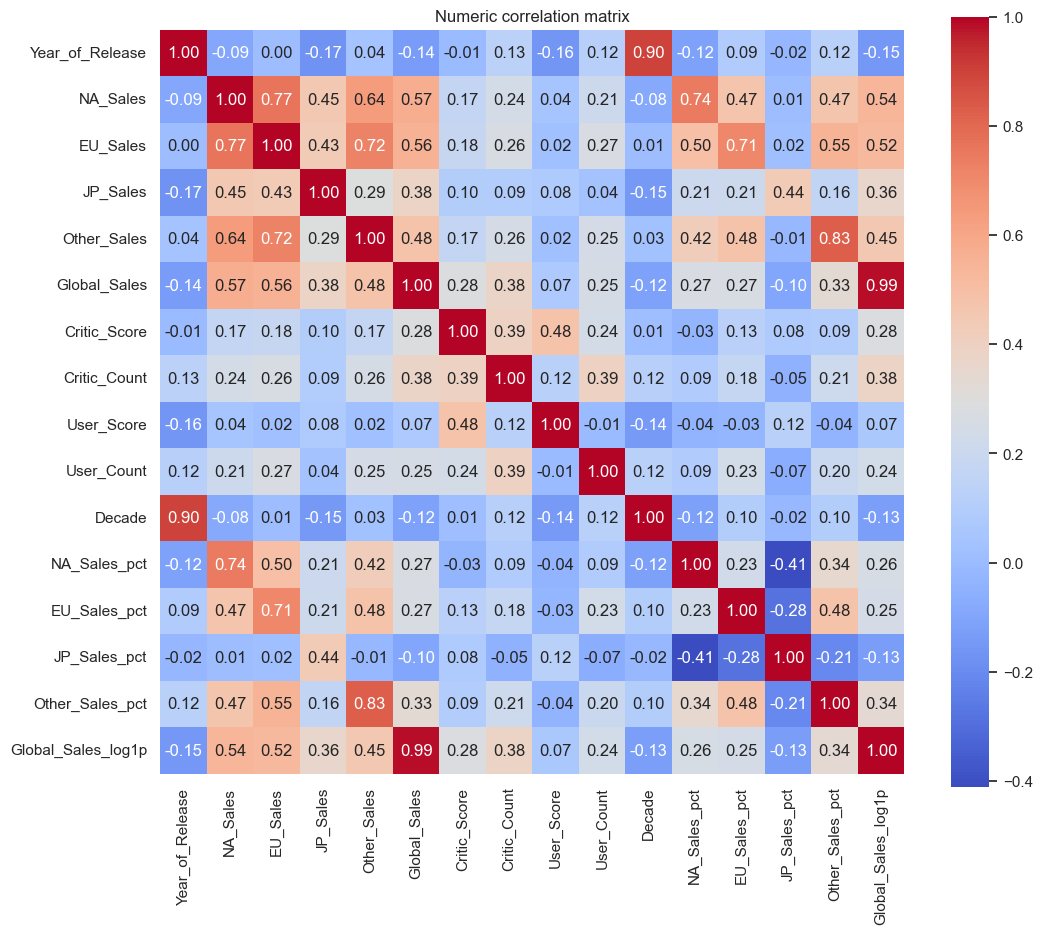

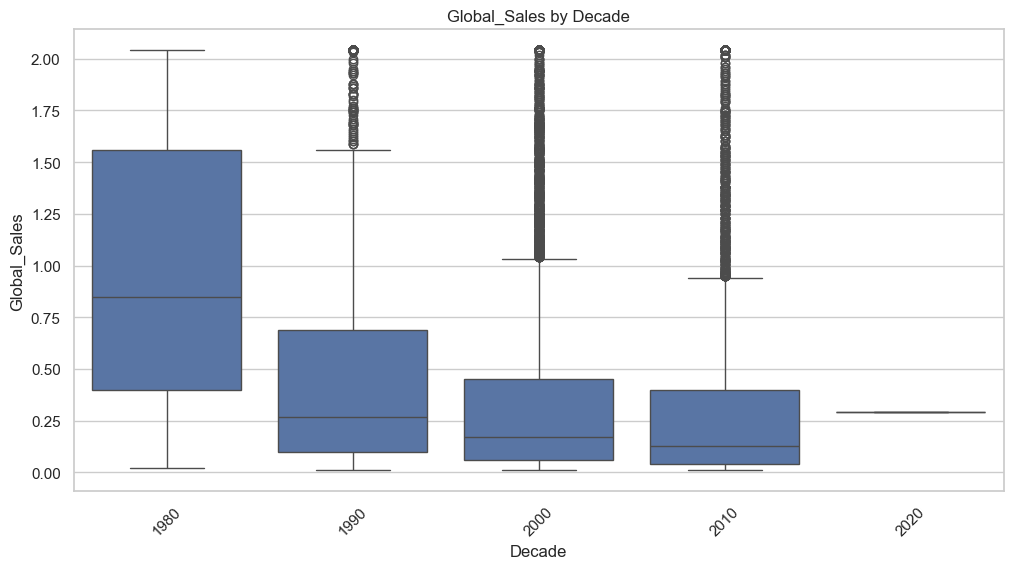

In [29]:
def run_eda(df):
    # Set Seaborn theme
    sns.set_theme(style="whitegrid")

    # Distribution of Global_Sales (raw)
    plt.figure(figsize=(8,4))
    plt.hist(df["Global_Sales"].dropna(), bins=50)
    plt.title("Global_Sales distribution (raw)")
    plt.xlabel("Global_Sales")
    plt.ylabel("Frequency")
    plt.show()

    # Distribution of Global_Sales (log1p)
    plt.figure(figsize=(8,4))
    plt.hist(np.log1p(df["Global_Sales"].dropna()), bins=50)
    plt.title("Global_Sales distribution (log1p)")
    plt.xlabel("log1p(Global_Sales)")
    plt.ylabel("Frequency")
    plt.show()

    # Top 15 categories for Platform, Genre, Publisher_reduced
    for col in ["Platform", "Genre", "Publisher_reduced"]:
        if col in df.columns:
            top = df[col].value_counts().nlargest(15)
            plt.figure(figsize=(10,6))
            sns.barplot(x=top.values, y=top.index)
            plt.title(f"Top 15 {col}")
            plt.show()

    # Critic_Score vs Global_Sales scatterplot
    if {"Critic_Score", "Global_Sales"}.issubset(df.columns):
        plt.figure(figsize=(8,5))
        sns.scatterplot(x="Critic_Score", y="Global_Sales", data=df, alpha=0.5)
        plt.title("Critic_Score vs Global_Sales")
        plt.show()

    # Correlation heatmap of numeric features
    numeric = df.select_dtypes(include=[np.number])
    if not numeric.empty:
        corr = numeric.corr().round(3)
        plt.figure(figsize=(12,10))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
        plt.title("Numeric correlation matrix")
        plt.show()

    # Global_Sales by Decade
    if "Decade" in df.columns:
        plt.figure(figsize=(12,6))
        sns.boxplot(x="Decade", y="Global_Sales", data=df)
        plt.title("Global_Sales by Decade")
        plt.xticks(rotation=45)
        plt.show()

# Run EDA on the cleaned dataset
run_eda(df_clean)


# Model Preparation and Training
Prepares features and target, splits dataset, creates preprocessing pipelines, trains multiple regression models, performs cross-validation, and evaluates performance.


In [30]:
def prepare_and_train(df):
    # Drop leakage columns (regional sales that directly compose global sales)
    leakage_cols = {"NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales",
                    "NA_Sales_pct", "EU_Sales_pct", "JP_Sales_pct", "Other_Sales_pct"}
    df = df.copy()
    for c in leakage_cols:
        if c in df.columns:
            df.drop(columns=c, inplace=True)

    # Define features and target
    potential_features = ["Platform", "Genre", "Publisher_reduced", "Year_of_Release", "Decade",
                          "Critic_Score", "User_Score", "Critic_Count", "User_Count"]
    features = [c for c in potential_features if c in df.columns]
    target_col = "Global_Sales_log1p"

    X = df[features]
    y = df[target_col]

    # Train/validation/test split (70/15/15)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=VAL_SIZE, random_state=RANDOM_STATE)

    # Separate numeric and categorical features
    numeric_features = [c for c in X_train.columns if X_train[c].dtype.kind in "biufc"]
    categorical_features = [c for c in X_train.columns if c not in numeric_features]

    # Preprocessing pipelines (per report specifications)
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

    # Models to train
    models = {
        "LinearRegression": LinearRegression(),
        "DecisionTree": DecisionTreeRegressor(max_depth=8, random_state=RANDOM_STATE),
        "RandomForest": RandomForestRegressor(
            n_estimators=100, max_depth=12, random_state=RANDOM_STATE, n_jobs=-1)
    }

    results = []
    fitted_pipelines = {}
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining & evaluating: {name}")
        pipe = Pipeline([("pre", preprocessor), ("model", model)])
        try:
            cv_scores = cross_val_score(pipe, X_train, y_train, cv=kf, scoring="r2", n_jobs=1)
            cv_r2_mean = float(np.mean(cv_scores))
        except:
            cv_r2_mean = np.nan

        pipe.fit(X_train, y_train)
        y_val_pred = pipe.predict(X_val)
        y_test_pred = pipe.predict(X_test)

        val_metrics = evaluate(y_val, y_val_pred)
        test_metrics = evaluate(y_test, y_test_pred)

        print(f"  CV R2: {cv_r2_mean:.4f}, Val R2: {val_metrics['r2']:.4f}, Test R2: {test_metrics['r2']:.4f}")

        results.append({
            "model": name,
            "cv_r2_mean": cv_r2_mean,
            "val_r2": val_metrics["r2"],
            "val_rmse": val_metrics["rmse"],
            "val_mae": val_metrics["mae"],
            "test_r2": test_metrics["r2"],
            "test_rmse": test_metrics["rmse"],
            "test_mae": test_metrics["mae"]
        })

        fitted_pipelines[name] = pipe

    results_df = pd.DataFrame(results).sort_values("test_r2", ascending=False)
    return results_df, fitted_pipelines, X_train, X_val, X_test, y_train, y_val, y_test


# Run Modeling and Save Results
Executes the training function, saves all results to CSV, and prints the best model according to test R².


In [31]:
# Run the modeling
results_df, pipelines, X_train, X_val, X_test, y_train, y_val, y_test = prepare_and_train(df_clean)

# Save results
results_df.to_csv(RESULTS_CSV, index=False)
print(f"Model results saved to '{RESULTS_CSV}'")

# Best model
best = results_df.iloc[0]
print("Best model (by test R²):")
print(best.to_dict())



Training & evaluating: LinearRegression
  CV R2: 0.3839, Val R2: 0.3887, Test R2: 0.3884

Training & evaluating: DecisionTree
  CV R2: 0.3839, Val R2: 0.3887, Test R2: 0.3884

Training & evaluating: DecisionTree
  CV R2: 0.4000, Val R2: 0.4120, Test R2: 0.3638

Training & evaluating: RandomForest
  CV R2: 0.4000, Val R2: 0.4120, Test R2: 0.3638

Training & evaluating: RandomForest
  CV R2: 0.4994, Val R2: 0.4889, Test R2: 0.4734
Model results saved to 'model_results.csv'
Best model (by test R²):
{'model': 'RandomForest', 'cv_r2_mean': 0.4993839203089805, 'val_r2': 0.48892805014703555, 'val_rmse': 0.22433169628106409, 'val_mae': 0.15668619286503727, 'test_r2': 0.47338818513278713, 'test_rmse': 0.2166749696435804, 'test_mae': 0.15113469983339967}
  CV R2: 0.4994, Val R2: 0.4889, Test R2: 0.4734
Model results saved to 'model_results.csv'
Best model (by test R²):
{'model': 'RandomForest', 'cv_r2_mean': 0.4993839203089805, 'val_r2': 0.48892805014703555, 'val_rmse': 0.22433169628106409, 'va